# Import sagemaker dependencies

In [1]:
import sagemaker
import boto3

sagemaker.config INFO - Not applying SDK defaults from location: C:\ProgramData\sagemaker\sagemaker\config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: C:\Users\Acer\AppData\Local\sagemaker\sagemaker\config.yaml


# import required libraries

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from imblearn.over_sampling import SMOTE


from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from xgboost import XGBClassifier


import warnings
warnings.filterwarnings('ignore')

# Load the data

In [3]:
df = pd.read_csv("src\data\steel_plant_motor_coupler_breakdown_data.csv")

In [4]:
df.head()

,Component_Type,Equipment_ID,Running_Hours_Since_Last_Maintenance,Ambient_Temperature_C,Vibration_Level_mm_s,Motor_Load_%,Coupler_Torque_Nm,Bearing_Temperature_C,Lubrication_Status,Power_Consumption_kW,Noise_Level_dB,Phase_Imbalance_%,Previous_Breakdown_Count,Maintenance_Frequency_days,Equipment_Age_years,Breakdown
0,Motor,EQUIP_0000,456,43.3,4.04,82,132.1,51.5,OK,83.02,82.3,1.22,1,30,5,0
1,Coupler,EQUIP_0001,154,44.0,3.09,85,148.9,60.9,Low,76.04,64.5,0.77,1,60,14,0
2,Motor,EQUIP_0002,210,39.7,2.56,38,118.7,53.7,OK,54.32,79.7,0.63,1,60,7,0
3,Motor,EQUIP_0003,426,36.7,3.07,51,186.8,55.1,OK,85.96,66.8,1.82,4,15,9,0
4,Motor,EQUIP_0004,221,51.0,2.71,42,133.6,56.8,OK,90.47,69.7,1.26,4,45,12,0


# Data pre-processing & data wrangling

In [5]:
df.describe()

,Running_Hours_Since_Last_Maintenance,Ambient_Temperature_C,Vibration_Level_mm_s,Motor_Load_%,Coupler_Torque_Nm,Bearing_Temperature_C,Power_Consumption_kW,Noise_Level_dB,Phase_Imbalance_%,Previous_Breakdown_Count,Maintenance_Frequency_days,Equipment_Age_years,Breakdown
count,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,249.27600,40.169500,3.057310,64.757000,151.041500,59.762400,75.240720,69.945600,1.970370,1.515000,37.785000,7.292000,0.038000
std,141.10929,5.081494,0.988573,19.866823,29.218191,9.931554,15.091026,5.100029,0.968531,1.269404,16.989921,4.069803,0.191292
min,10.00000,23.200000,0.500000,30.000000,70.900000,22.900000,32.780000,53.000000,0.000000,0.000000,15.000000,1.000000,0.000000
25%,126.00000,36.775000,2.380000,47.000000,131.600000,52.900000,65.122500,66.500000,1.300000,1.000000,15.000000,4.000000,0.000000
50%,251.50000,40.100000,3.095000,65.000000,150.300000,60.100000,75.285000,69.900000,1.965000,1.000000,45.000000,7.000000,0.000000
75%,369.00000,43.525000,3.740000,82.000000,170.525000,66.600000,85.702500,73.325000,2.632500,2.000000,60.000000,11.000000,0.000000
max,498.00000,55.800000,6.500000,99.000000,259.700000,88.400000,128.330000,85.500000,5.050000,8.000000,60.000000,14.000000,1.000000


In [6]:
df.isnull().sum()

Component_Type                          0
Equipment_ID                            0
Running_Hours_Since_Last_Maintenance    0
Ambient_Temperature_C                   0
Vibration_Level_mm_s                    0
Motor_Load_%                            0
Coupler_Torque_Nm                       0
Bearing_Temperature_C                   0
Lubrication_Status                      0
Power_Consumption_kW                    0
Noise_Level_dB                          0
Phase_Imbalance_%                       0
Previous_Breakdown_Count                0
Maintenance_Frequency_days              0
Equipment_Age_years                     0
Breakdown                               0
dtype: int64

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 16 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Component_Type                        1000 non-null   object 
 1   Equipment_ID                          1000 non-null   object 
 2   Running_Hours_Since_Last_Maintenance  1000 non-null   int64  
 3   Ambient_Temperature_C                 1000 non-null   float64
 4   Vibration_Level_mm_s                  1000 non-null   float64
 5   Motor_Load_%                          1000 non-null   int64  
 6   Coupler_Torque_Nm                     1000 non-null   float64
 7   Bearing_Temperature_C                 1000 non-null   float64
 8   Lubrication_Status                    1000 non-null   object 
 9   Power_Consumption_kW                  1000 non-null   float64
 10  Noise_Level_dB                        1000 non-null   float64
 11  Phase_Imbalance_% 

In [8]:
df.drop("Equipment_ID", axis=1, inplace=True)

In [9]:
for i in df.columns:
    if df[i].dtype == "O":
        print(i, " ", df[i].dtype)

Component_Type   object
Lubrication_Status   object


In [10]:
le = LabelEncoder()

df['Component_Type'] = le.fit_transform(df['Component_Type'])
df['Lubrication_Status'] = le.fit_transform(df['Lubrication_Status'])

In [11]:
df.head()

,Component_Type,Running_Hours_Since_Last_Maintenance,Ambient_Temperature_C,Vibration_Level_mm_s,Motor_Load_%,Coupler_Torque_Nm,Bearing_Temperature_C,Lubrication_Status,Power_Consumption_kW,Noise_Level_dB,Phase_Imbalance_%,Previous_Breakdown_Count,Maintenance_Frequency_days,Equipment_Age_years,Breakdown
0,1,456,43.3,4.04,82,132.1,51.5,1,83.02,82.3,1.22,1,30,5,0
1,0,154,44.0,3.09,85,148.9,60.9,0,76.04,64.5,0.77,1,60,14,0
2,1,210,39.7,2.56,38,118.7,53.7,1,54.32,79.7,0.63,1,60,7,0
3,1,426,36.7,3.07,51,186.8,55.1,1,85.96,66.8,1.82,4,15,9,0
4,1,221,51.0,2.71,42,133.6,56.8,1,90.47,69.7,1.26,4,45,12,0


# Exploratory data analysys

In [12]:
df.corr()

,Component_Type,Running_Hours_Since_Last_Maintenance,Ambient_Temperature_C,Vibration_Level_mm_s,Motor_Load_%,Coupler_Torque_Nm,Bearing_Temperature_C,Lubrication_Status,Power_Consumption_kW,Noise_Level_dB,Phase_Imbalance_%,Previous_Breakdown_Count,Maintenance_Frequency_days,Equipment_Age_years,Breakdown
Component_Type,1.000000,0.002138,0.052834,0.009350,-0.039584,0.004971,0.001960,0.020847,-0.011822,-0.010417,0.023410,-0.024202,0.022423,0.024549,-0.048337
Running_Hours_Since_Last_Maintenance,0.002138,1.000000,-0.007161,0.069162,0.015905,0.013013,0.017334,-0.032498,0.015315,0.062344,-0.033993,-0.014575,0.013000,-0.022596,0.189776
Ambient_Temperature_C,0.052834,-0.007161,1.000000,-0.000634,0.041883,-0.023050,-0.017804,0.042190,0.007202,0.010694,0.035337,0.016947,0.025780,0.008616,-0.001896
Vibration_Level_mm_s,0.009350,0.069162,-0.000634,1.000000,-0.014847,-0.012403,-0.032972,-0.017764,-0.012448,-0.020422,0.045211,0.020042,-0.027198,-0.033246,0.024096
Motor_Load_%,-0.039584,0.015905,0.041883,-0.014847,1.000000,-0.008482,0.038482,-0.059207,0.019750,-0.014787,-0.003852,-0.055484,0.011438,-0.039259,0.008490
Coupler_Torque_Nm,0.004971,0.013013,-0.023050,-0.012403,-0.008482,1.000000,-0.006760,-0.059342,0.043672,-0.038314,0.001241,-0.001230,0.070934,-0.001953,0.002655
Bearing_Temperature_C,0.001960,0.017334,-0.017804,-0.032972,0.038482,-0.006760,1.000000,-0.053573,0.083436,0.040098,0.042185,0.002871,-0.047561,-0.022282,0.114614
Lubrication_Status,0.020847,-0.032498,0.042190,-0.017764,-0.059207,-0.059342,-0.053573,1.000000,-0.063533,0.047476,-0.030845,-0.015656,-0.058392,0.033257,-0.274153
Power_Consumption_kW,-0.011822,0.015315,0.007202,-0.012448,0.019750,0.043672,0.083436,-0.063533,1.000000,-0.031996,-0.055921,0.044210,0.036733,-0.015379,-0.020610
Noise_Level_dB,-0.010417,0.062344,0.010694,-0.020422,-0.014787,-0.038314,0.040098,0.047476,-0.031996,1.000000,-0.004089,0.026752,-0.000670,-0.045430,0.033826


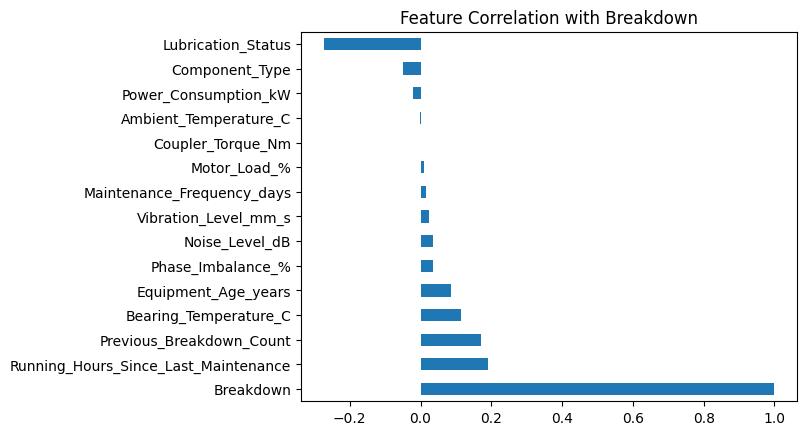

In [13]:
df.corr()['Breakdown'].sort_values(ascending=False).plot(kind='barh')
plt.title('Feature Correlation with Breakdown')
plt.show()

In [14]:
df['Breakdown'].value_counts()

Breakdown
0    962
1     38
Name: count, dtype: int64

In [15]:
### this is not a balanced data set. hence use SMOTE

In [16]:
X = df.drop('Breakdown', axis=1)
y = df['Breakdown']

In [39]:
X

,Component_Type,Running_Hours_Since_Last_Maintenance,Ambient_Temperature_C,Vibration_Level_mm_s,Motor_Load_%,Coupler_Torque_Nm,Bearing_Temperature_C,Lubrication_Status,Power_Consumption_kW,Noise_Level_dB,Phase_Imbalance_%,Previous_Breakdown_Count,Maintenance_Frequency_days,Equipment_Age_years
0,1,456,43.3,4.04,82,132.1,51.5,1,83.02,82.3,1.22,1,30,5
1,0,154,44.0,3.09,85,148.9,60.9,0,76.04,64.5,0.77,1,60,14
2,1,210,39.7,2.56,38,118.7,53.7,1,54.32,79.7,0.63,1,60,7
3,1,426,36.7,3.07,51,186.8,55.1,1,85.96,66.8,1.82,4,15,9
4,1,221,51.0,2.71,42,133.6,56.8,1,90.47,69.7,1.26,4,45,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,1,380,39.4,2.90,73,151.0,71.8,1,81.73,70.0,2.92,5,30,1
996,1,185,44.1,3.31,76,108.5,63.4,1,93.33,83.2,1.52,3,45,1
997,0,337,37.1,2.96,69,83.3,64.0,1,99.10,77.4,2.69,1,30,3
998,0,324,44.2,4.55,80,171.7,73.3,0,108.65,62.1,2.23,0,15,6


In [20]:
y.value_counts()

Breakdown
0    962
1     38
Name: count, dtype: int64

In [17]:
# to make the data is balance, use SMOTE 

sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X, y)

In [21]:
print("Before SMOTE: ", y.value_counts())
print("After SMOTE: ",y_res.value_counts())
      

Before SMOTE:  Breakdown
0    962
1     38
Name: count, dtype: int64
After SMOTE:  Breakdown
0    962
1    962
Name: count, dtype: int64


# Train and test dat split & normalization of data

In [23]:
X_train, X_test, y_train,y_test = train_test_split(X_res, y_res, random_state=43, test_size=0.2)

standard = StandardScaler()

In [24]:
X_train = standard.fit_transform(X_train)
X_test = standard.fit_transform(X_test)

# Validate all the models

In [26]:
# Validate all the models
models = {
    'Logistic Regression': LogisticRegression(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'KNN': KNeighborsClassifier(),
    'Naive Bayes': GaussianNB(),
    'SVM': SVC(probability=True),
    'AdaBoost': AdaBoostClassifier(),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss')
}

In [27]:
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"\n{name} Classification Report:")
    print(classification_report(y_test, y_pred))
    print("ROC AUC Score:", roc_auc_score(y_test, model.predict_proba(X_test)[:,1]))


Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.94      0.88       166
           1       0.95      0.85      0.90       219

    accuracy                           0.89       385
   macro avg       0.89      0.90      0.89       385
weighted avg       0.90      0.89      0.89       385

ROC AUC Score: 0.9801397370303131

Decision Tree Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.94      0.90       166
           1       0.95      0.89      0.92       219

    accuracy                           0.91       385
   macro avg       0.91      0.92      0.91       385
weighted avg       0.92      0.91      0.91       385

ROC AUC Score: 0.917368102547175

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.97      0.97       166
           1       0.98      0.98      0.98       

# Use the randomforest classifier after comparing all the models

## Hyperparameter tuning for Randomforeset model

In [29]:
param_grid = {
    'n_estimators':[50, 100, 200],
    'max_depth' : [None, 10, 20],
    'min_samples_split':[2, 5, 10]
}

grid = GridSearchCV(RandomForestClassifier(), param_grid, cv = 3, scoring='f1', n_jobs=1)
grid.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=1,
             param_grid={'max_depth': [None, 10, 20],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200]},
             scoring='f1')

In [30]:
print('Best parameters: ', grid.best_params_)

Best parameters:  {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 200}


In [44]:
best_model = grid.best_estimator_

In [46]:
import joblib

In [47]:
model_path = "src\models\model.joblib"

joblib.dump(best_model, model_path)

print(f"Model saved to {model_path}")

Model saved to src\models\model.joblib


In [48]:
load_model = joblib.load(model_path)

In [49]:
df.head(1)

,Component_Type,Running_Hours_Since_Last_Maintenance,Ambient_Temperature_C,Vibration_Level_mm_s,Motor_Load_%,Coupler_Torque_Nm,Bearing_Temperature_C,Lubrication_Status,Power_Consumption_kW,Noise_Level_dB,Phase_Imbalance_%,Previous_Breakdown_Count,Maintenance_Frequency_days,Equipment_Age_years,Breakdown
0,1,456,43.3,4.04,82,132.1,51.5,1,83.02,82.3,1.22,1,30,5,0


In [50]:
X_train[0]

array([-0.71331867, -0.42200634,  1.19038444,  0.07806247,  1.07305446,
       -0.5921556 , -0.51079606,  1.13586028, -0.47167135, -1.18966723,
        0.20074162,  0.0531343 ,  1.31142309, -1.46193203])

In [54]:
load_model.predict([[1,456,43.3,4.04,82,132.1,51.5,1,83.02,82.3,1.22,1,30,5]])[0]

0